# **Predictive Analytics**

- Import Library

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

- Load Data

Information : 
- Radiation : Radiasi Solar watts per meter^2
- Temperature : Suhu dalam derajat Fahrenheit
- Humidity : Percent
- Barometric Pressure : Hg
- Wind Direction : Degrees
- Wind Speed : miles per hour
- Sunrise & Sunset : hawai time

In [20]:
df = pd.read_csv('../data/raw/SolarPrediction.csv', parse_dates=['Time'])

C:\Users\acer\AppData\Local\Temp\ipykernel_13620\2920403303.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('../data/raw/SolarPrediction.csv', parse_dates=['Time'])


## Exploration Data Analysis

In [21]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,2025-05-24 23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,2025-05-24 23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,2025-05-24 23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,2025-05-24 23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,2025-05-24 23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [22]:
df.dtypes

UNIXTime                           int64
Data                              object
Time                      datetime64[ns]
Radiation                        float64
Temperature                        int64
Pressure                         float64
Humidity                           int64
WindDirection(Degrees)           float64
Speed                            float64
TimeSunRise                       object
TimeSunSet                        object
dtype: object

## Data Preprocessing

In [23]:
def time_to_minutes(t):
    return t.hour * 60 + t.minute + t.second / 60

In [ ]:
df['Temperature'] = df['Temperature'].astype(float)
df['Humidity'] = df['Humidity'].astype(float)
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'], format="%H:%M:%S").dt.time
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'], format="%H:%M:%S").dt.time

df['SunRiseMinutes'] = df['TimeSunRise'].apply(time_to_minutes)
df['SunSetMinutes'] = df['TimeSunSet'].apply(time_to_minutes)
df['CurrentMinutes'] = df['Time'].apply(time_to_minutes)
df['MinutesSinceSunrise'] = df['CurrentMinutes'] - df['SunRiseMinutes']
df['MinutesUntilSunset'] = df['SunSetMinutes'] - df['CurrentMinutes']
df['DaylightDuration'] = df['SunSetMinutes'] - df['SunRiseMinutes']
df = df.drop(columns=['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'])

<Axes: >

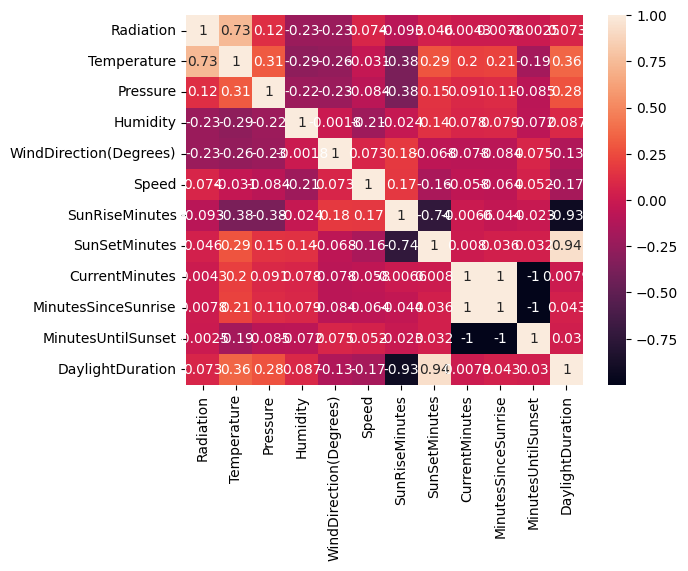

In [25]:
sns.heatmap(df.corr(), annot=True)


In [26]:
df.isna().sum()


Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
SunRiseMinutes            0
SunSetMinutes             0
CurrentMinutes            0
MinutesSinceSunrise       0
MinutesUntilSunset        0
DaylightDuration          0
dtype: int64

In [27]:
numeric =  df.select_dtypes(include="number").columns


In [28]:
for i in numeric:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outlier = df[(df[i] < lower) | (df[i] > upper)]
    print(f"Kolom {i} : {len(outlier)} outlier")

Kolom Radiation : 1965 outlier
Kolom Temperature : 89 outlier
Kolom Pressure : 1662 outlier
Kolom Humidity : 0 outlier
Kolom WindDirection(Degrees) : 1618 outlier
Kolom Speed : 479 outlier
Kolom SunRiseMinutes : 0 outlier
Kolom SunSetMinutes : 0 outlier
Kolom CurrentMinutes : 0 outlier
Kolom MinutesSinceSunrise : 0 outlier
Kolom MinutesUntilSunset : 0 outlier
Kolom DaylightDuration : 0 outlier


In [29]:
def outlierhandling(series):
    Q1 = df[series].quantile(0.25)
    Q3 = df[series].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df.loc[df[series] > upper, series] = upper
    df.loc[df[series] < lower, series] = lower
    return df

In [30]:
for i in numeric:
    df = outlierhandling(i)
for i in numeric:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outlier = df[(df[i] < lower) | (df[i] > upper)]
    print(f"Kolom {i} : {len(outlier)} outlier")

Kolom Radiation : 0 outlier
Kolom Temperature : 0 outlier
Kolom Pressure : 0 outlier
Kolom Humidity : 0 outlier
Kolom WindDirection(Degrees) : 0 outlier
Kolom Speed : 0 outlier
Kolom SunRiseMinutes : 0 outlier
Kolom SunSetMinutes : 0 outlier
Kolom CurrentMinutes : 0 outlier
Kolom MinutesSinceSunrise : 0 outlier
Kolom MinutesUntilSunset : 0 outlier
Kolom DaylightDuration : 0 outlier


In [31]:
X = df.drop('Radiation',axis=1)
y = df['Radiation']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelling & Evaluasi

In [32]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1)
])
model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
model.summary()

d:\Dicoding\Predictive-Analytic\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,937 (687.25 KB)

 Trainable params: 175,937 (687.25 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
callback = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6,verbose=1),
    ModelCheckpoint(filepath='../models/best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

In [34]:
history = model.fit(X_train_scaled,y_train, validation_split=0.2, batch_size=64, epochs=100, callbacks=[callback])

Epoch 1/100
323/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 62479.9844 - mae: 152.9926
Epoch 1: val_loss improved from inf to 14440.06250, saving model to ../models/best_model.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 62031.4219 - mae: 152.2493 - val_loss: 14440.0625 - val_mae: 63.4727 - learning_rate: 0.0010
Epoch 2/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13599.5928 - mae: 60.8820
Epoch 2: val_loss improved from 14440.06250 to 10960.15723, saving model to ../models/best_model.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 13595.6689 - mae: 60.8703 - val_loss: 10960.1572 - val_mae: 53.5632 - learning_rate: 0.0010
Epoch 3/100
317/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10885.1211 - mae: 52.4312
Epoch 3: val_loss improved from 10960.15723 to 9957.43164, saving model to ../models/best_model.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 10883.4785 - mae: 52.4442 - val_loss: 9957.4316 - val_mae: 50.7635 - learning_rate: 0.0010
Epoch 4/100
323

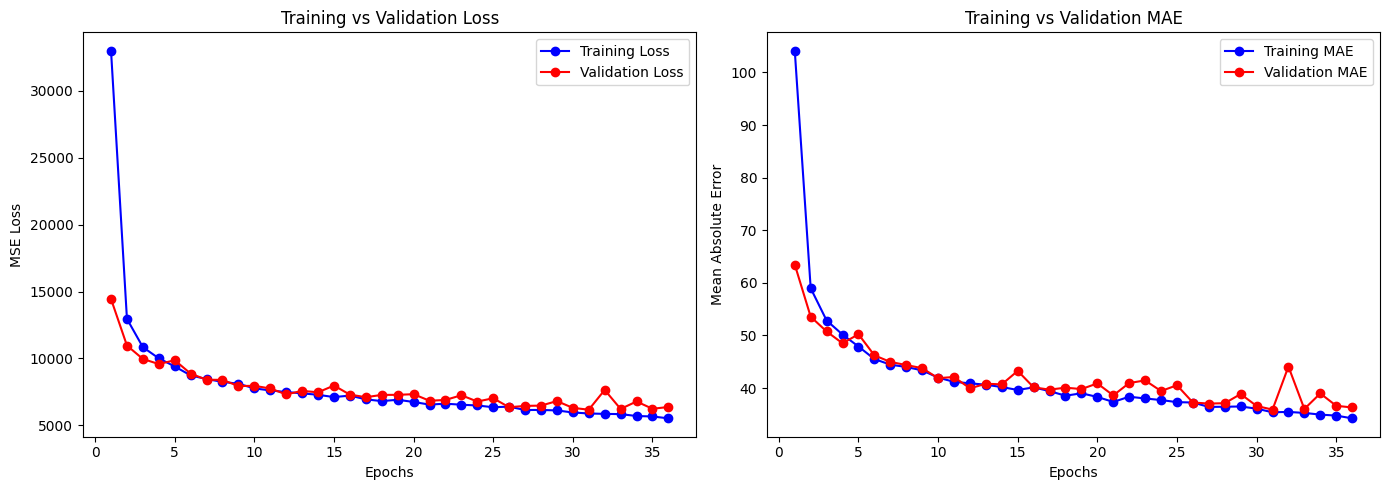

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'bo-', label='Training MAE')
plt.plot(epochs, val_mae, 'ro-', label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
val_mae = history.history['val_mae'][-1]
mae_percent = (val_mae / y_test.mean()) * 100
print(f"MAE sekitar {mae_percent:.2f}% dari rata-rata radiation")

MAE sekitar 18.39% dari rata-rata radiation


## Testing